In [6]:
!pip install -q efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.1 MB/s eta 0:00:00


# Check GPU working

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import Xception
from efficientnet.keras import EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input


In [8]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [9]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)

Found GPU at: /device:GPU:0


## Setup path

In [10]:
TRAIN_PATH = '/content/drive/MyDrive/ajmal/Dish_classification/uehvdr_dataset/output/train'
VALIDATE_PATH = '/content/drive/MyDrive/ajmal/Dish_classification/uehvdr_dataset/output/val'
TEST_PATH = '/content/drive/MyDrive/ajmal/Dish_classification/uehvdr_dataset/output/test'

In [ ]:
def save_model(PATH):
  BASE_MODEL_BEST = os.path.join(PATH, 'base_model_best.hdf5')
  BASE_MODEL_TRAINED = os.path.join(PATH, 'base_model_trained.hdf5')
  BASE_MODEL_FIG = os.path.join(PATH, 'base_model_fig.jpg')
  FINE_TUNE_MODEL_BEST = os.path.join(PATH, 'fine_tune_model_best.hdf5')
  FINE_TUNE_MODEL_TRAINED = os.path.join(PATH, 'fine_tune_model_trained.hdf5')
  FINE_TUNE_MODE_FIG = os.path.join(PATH, 'fine_tune_model_fig.jpg')
  return BASE_MODEL_BEST, BASE_MODEL_TRAINED, BASE_MODEL_FIG, FINE_TUNE_MODEL_BEST, FINE_TUNE_MODEL_TRAINED, FINE_TUNE_MODE_FIG

## Preparing data

In [11]:
IMAGE_SIZE = (300, 300)
BATCH_SIZE = 128


train_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)
validate_generator = ImageDataGenerator(rescale=1./255)
test_generator = ImageDataGenerator(rescale=1./255)


generated_train_data = train_generator.flow_from_directory(TRAIN_PATH, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
generated_validate_data = validate_generator.flow_from_directory(VALIDATE_PATH, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
generated_test_data = test_generator.flow_from_directory(TEST_PATH, target_size=IMAGE_SIZE)

Found 6273 images belonging to 9 classes.
Found 780 images belonging to 9 classes.
Found 795 images belonging to 9 classes.


## Model constants

In [ ]:
CLASSES = 9
INITIAL_EPOCHS = 15
FINE_TUNE_EPOCHS = 15
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS
FINE_TUNE_AT = 116

# Define the model
# 1. Xception

In [ ]:
# iniatialize the save path
PATH = '/content/drive/MyDrive/Dish_classification/Models/Xception'
BASE_MODEL_BEST, BASE_MODEL_TRAINED, BASE_MODEL_FIG, FINE_TUNE_MODEL_BEST, FINE_TUNE_MODEL_TRAINED, FINE_TUNE_MODE_FIG = save_model(PATH)

#Callbacks

In [ ]:
base_checkpointer = ModelCheckpoint(
    filepath = BASE_MODEL_BEST,
    save_best_only = True,
    verbose = 1
)

fine_tune_checkpointer = ModelCheckpoint(
    filepath = FINE_TUNE_MODEL_BEST,
    save_best_only = True,
    verbose = 1,
)

# Stop if no improvement after 3 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [ ]:
pretrained_model = Xception(weights='imagenet', include_top=False)
last_output = pretrained_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=pretrained_model.input, outputs=outputs)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 32)       864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, None, None, 32)       128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, None, None, 32)       0         ['block1_conv1_bn[0][0]'

# Stage 1: Transfer learning

In [ ]:
for layer in pretrained_model.layers: layer.trainable = False
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(
    generated_train_data,
    validation_data = generated_validate_data,
    validation_steps = generated_validate_data.n // BATCH_SIZE,
    steps_per_epoch = generated_train_data.n // BATCH_SIZE,
    callbacks = [base_checkpointer, early_stopping],
    epochs = INITIAL_EPOCHS,
    verbose = 1,
)
model.save(BASE_MODEL_TRAINED)

Epoch 1/15
49/49 [==============================] - ETA: 0s - loss: 0.9298 - accuracy: 0.6924 
Epoch 1: val_loss improved from inf to 0.45710, saving model to /content/drive/MyDrive/ajmal/Dish_classification/Models/Xception/base_model_best.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 2276s 46s/step - loss: 0.9298 - accuracy: 0.6924 - val_loss: 0.4571 - val_accuracy: 0.8646
Epoch 2/15
49/49 [==============================] - ETA: 0s - loss: 0.5553 - accuracy: 0.8103
Epoch 2: val_loss improved from 0.45710 to 0.38052, saving model to /content/drive/MyDrive/ajmal/Dish_classification/Models/Xception/base_model_best.hdf5
49/49 [==============================] - 247s 5s/step - loss: 0.5553 - accuracy: 0.8103 - val_loss: 0.3805 - val_accuracy: 0.8815
Epoch 3/15
49/49 [==============================] - ETA: 0s - loss: 0.4738 - accuracy: 0.8366
Epoch 3: val_loss improved from 0.38052 to 0.37049, saving model to /content/drive/MyDrive/ajmal/Dish_classification/Models/Xception/base_model_best.hdf5
49/49 [==============================] - 246s 5s/step - loss: 0.4738 - accuracy: 0.8366 - val_loss: 0.3705 - val_accuracy: 0.8750
Epoch 4/15
49/49 [==============================] - ETA: 0s - loss: 0.4248 - accuracy: 0.8574
Epoch 4: val_loss 

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# function to plot the graphs

In [ ]:
def plot_graph(acc, loss, val_acc, val_loss, MODEL_FIG):

  plt.figure(figsize=(20, 5))
  plt.subplot(1, 2, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()), 1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([min(plt.ylim()), max(plt.ylim())])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.savefig(MODEL_FIG)
  return plt.show()

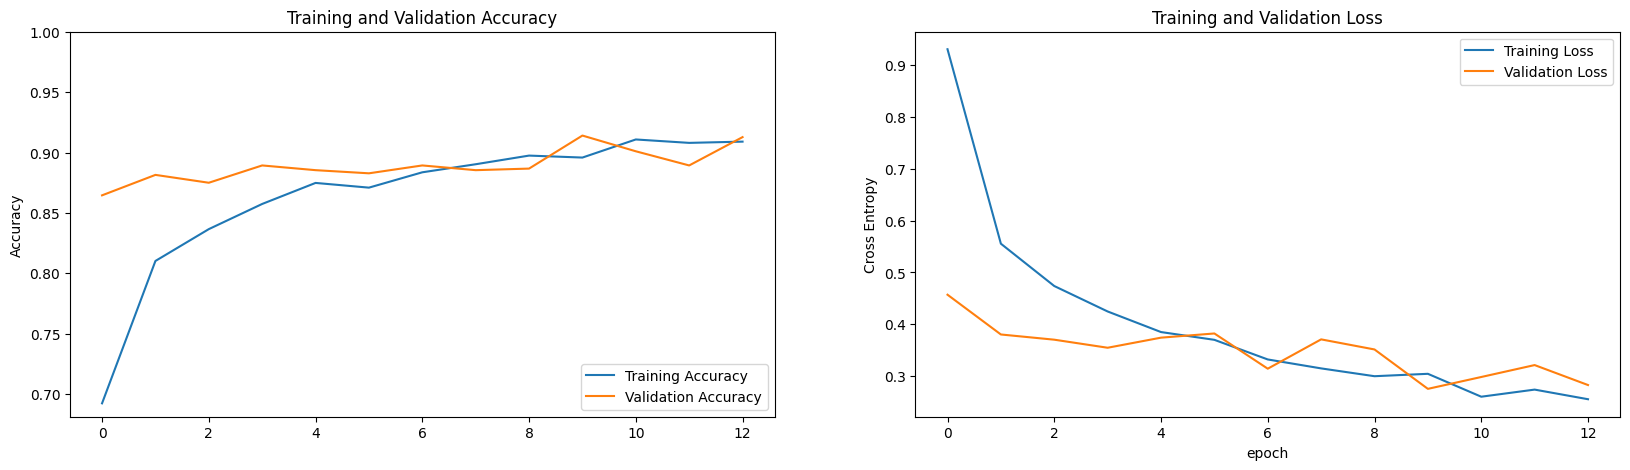

In [ ]:
plot_graph(acc, loss, val_acc, val_loss, BASE_MODEL_FIG)

# Stage 2: Fine tuning

In [ ]:
for layer in pretrained_model.layers[:FINE_TUNE_AT]: layer.trainable = False
for layer in pretrained_model.layers[FINE_TUNE_AT:]: layer.trainable = True

In [ ]:
model.compile(
    optimizer = SGD(learning_rate=1e-4, momentum=0.9),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
history_fine = model.fit(
    generated_train_data,
    validation_data = generated_validate_data,
    validation_steps = generated_validate_data.n // BATCH_SIZE,
    steps_per_epoch = generated_train_data.n // BATCH_SIZE,
    epochs = TOTAL_EPOCHS,
    initial_epoch = history.epoch[-1],
    callbacks = [fine_tune_checkpointer, early_stopping],
    verbose = 1,
)
model.save(FINE_TUNE_MODEL_TRAINED)

Epoch 13/30
49/49 [==============================] - ETA: 0s - loss: 0.6493 - accuracy: 0.7871
Epoch 13: val_loss improved from inf to 0.27368, saving model to /content/drive/MyDrive/ajmal/Dish_classification/Models/Xception/fine_tune_model_best.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 262s 5s/step - loss: 0.6493 - accuracy: 0.7871 - val_loss: 0.2737 - val_accuracy: 0.9154
Epoch 14/30
48/49 [============================>.] - ETA: 4s - loss: 0.4667 - accuracy: 0.8433
Epoch 14: val_loss did not improve from 0.27368
49/49 [==============================] - 246s 5s/step - loss: 0.4673 - accuracy: 0.8431 - val_loss: 0.2779 - val_accuracy: 0.9128
Epoch 15/30
49/49 [==============================] - ETA: 0s - loss: 0.3811 - accuracy: 0.8705
Epoch 15: val_loss did not improve from 0.27368
49/49 [==============================] - 250s 5s/step - loss: 0.3811 - accuracy: 0.8705 - val_loss: 0.2866 - val_accuracy: 0.9115
Epoch 16/30
49/49 [==============================] - ETA: 0s - loss: 0.3380 - accuracy: 0.8903
Epoch 16: val_loss did not improve from 0.27368
49/49 [==============================] - 244s 5s/step - loss: 0.3380 - accuracy: 0.8903 - val_loss: 0.2908 - val_accuracy: 0.9062
Epoch 16: early stopping


In [ ]:
acc += history_fine.history['accuracy']
loss += history_fine.history['loss']
val_acc += history_fine.history['val_accuracy']
val_loss += history_fine.history['val_loss']

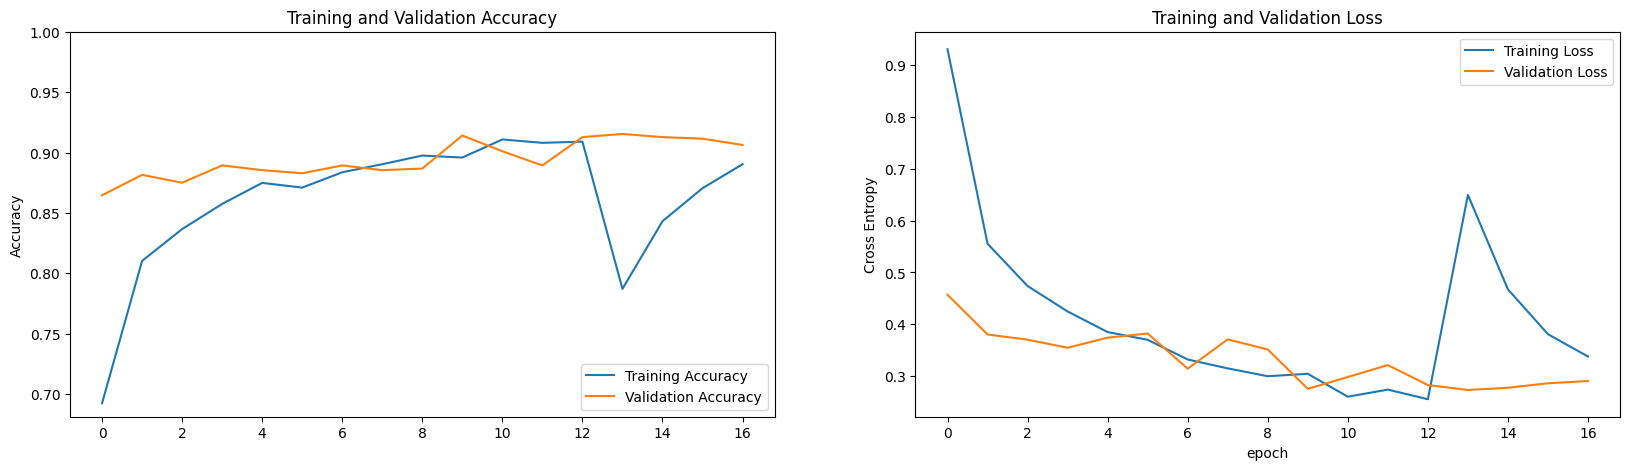

In [ ]:
plot_graph(acc, loss, val_acc, val_loss, FINE_TUNE_MODE_FIG)

# Evaluation

In [ ]:
loss, accuracy = model.evaluate(generated_test_data)
print('Test accuracy:', accuracy)

25/25 [==============================] - 241s 10s/step - loss: 0.3152 - accuracy: 0.8918
Test accuracy: 0.8918238878250122


# testing the model.

In [ ]:
# path for the model
FINE_TUNE_MODEL_PATH = '/content/drive/MyDrive/ajmal/Dish_classification/Models/Xception/fine_tune_model_best.hdf5'
BASE_MODEL_PATH = '/content/drive/MyDrive/ajmal/Dish_classification/Models/Xception/base_model_best.hdf5'

# Load the  model
BASE_MODEL = tf.keras.models.load_model(BASE_MODEL_PATH)
FINE_TUNE_MODEL = tf.keras.models.load_model(FINE_TUNE_MODEL_PATH)



In [ ]:
# Load and preprocess the image
def predicted_output(img_path, model, class_list):
  img = image.load_img(img_path, target_size=IMAGE_SIZE)
  x = image.img_to_array(img)
  x = preprocess_input(x)
  x = tf.expand_dims(x, axis=0)

  # Make the prediction
  predictions = model.predict(x)

  # Decode the prediction
  class_index = tf.argmax(predictions[0]).numpy()
  return class_list[class_index]

In [13]:
classes = generated_test_data.class_indices
class_list = [i for i in classes]
class_list

['Banh chung',
 'Banh mi',
 'Banh tet',
 'Banh trang',
 'Banh xeo',
 'Bun',
 'Com tam',
 'Goi cuon',
 'Pho']

In [ ]:
img_path = '/content/drive/MyDrive/ajmal/Dish_classification/uehvdr_dataset/output/test/Banh tet/106.jpg'
predictions_with_base = predicted_output(img_path, BASE_MODEL, class_list)
predictions_with_tuned = predicted_output(img_path, FINE_TUNE_MODEL, class_list)

print(f'Base predicted class is {predictions_with_base} and Tuned predicted class is {predictions_with_tuned}')

1/1 [==============================] - 0s 36ms/step
Base predicted class is Banh tet and Tuned predicted class is Banh tet


In [ ]:
# Make the prediction
img_path = '/content/drive/MyDrive/ajmal/Dish_classification/uehvdr_dataset/output/test/Bun/120.jpg'  # Replace with your image path
predictions_with_base = predicted_output(img_path, BASE_MODEL, class_list)
predictions_with_tuned = predicted_output(img_path, FINE_TUNE_MODEL, class_list)

print(f'Base predicted class is {predictions_with_base} and Tuned predicted class is {predictions_with_tuned}')

1/1 [==============================] - 0s 22ms/step
Base predicted class is Bun and Tuned predicted class is Bun


# 2. model VGG19

In [ ]:
# iniatialize the save path
PATH = '/content/drive/MyDrive/ajmal/Dish_classification/Models/VGG19'
BASE_MODEL_BEST, BASE_MODEL_TRAINED, BASE_MODEL_FIG, FINE_TUNE_MODEL_BEST, FINE_TUNE_MODEL_TRAINED, FINE_TUNE_MODE_FIG = save_model(PATH)

In [ ]:
pretrained_model = VGG19(weights='imagenet', include_top=False)
last_output = pretrained_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=pretrained_model.input, outputs=outputs)

# Stage 1: Transfer learning

In [ ]:
for layer in pretrained_model.layers: layer.trainable = False
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    generated_train_data,
    validation_data = generated_validate_data,
    validation_steps = generated_validate_data.n // BATCH_SIZE,
    steps_per_epoch = generated_train_data.n // BATCH_SIZE,
    callbacks = [base_checkpointer, early_stopping],
    epochs = INITIAL_EPOCHS,
    verbose = 1,
)
model.save(BASE_MODEL_TRAINED)

Epoch 1/15
49/49 [==============================] - ETA: 0s - loss: 1.9708 - accuracy: 0.2869
Epoch 1: val_loss did not improve from 0.27581
49/49 [==============================] - 288s 5s/step - loss: 1.9708 - accuracy: 0.2869 - val_loss: 1.6644 - val_accuracy: 0.3958
Epoch 2/15
49/49 [==============================] - ETA: 0s - loss: 1.5820 - accuracy: 0.4656
Epoch 2: val_loss did not improve from 0.27581
49/49 [==============================] - 249s 5s/step - loss: 1.5820 - accuracy: 0.4656 - val_loss: 1.3973 - val_accuracy: 0.5299
Epoch 3/15
49/49 [==============================] - ETA: 0s - loss: 1.4158 - accuracy: 0.5360
Epoch 3: val_loss did not improve from 0.27581
49/49 [==============================] - 246s 5s/step - loss: 1.4158 - accuracy: 0.5360 - val_loss: 1.2948 - val_accuracy: 0.5625
Epoch 4/15
49/49 [==============================] - ETA: 0s - loss: 1.2892 - accuracy: 0.5634
Epoch 4: val_loss did not improve from 0.27581
49/49 [==============================] - 246s 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

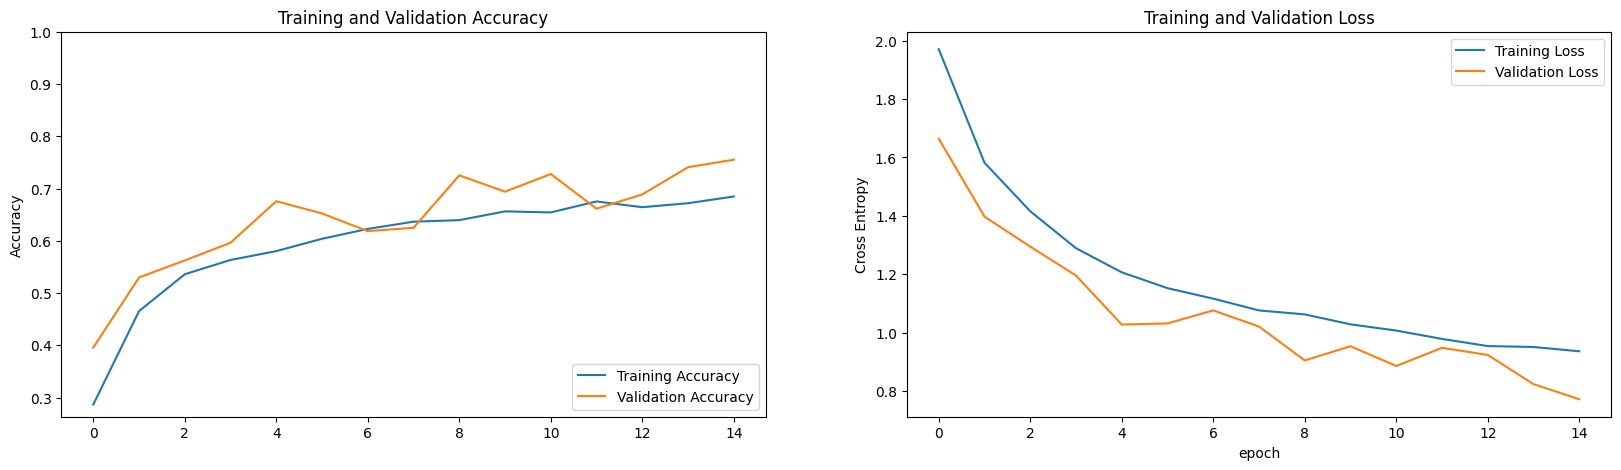

In [ ]:
plot_graph(acc, loss, val_acc, val_loss, BASE_MODEL_FIG)

# Stage 2: Fine tuning


In [ ]:
for layer in pretrained_model.layers[:FINE_TUNE_AT]: layer.trainable = False
for layer in pretrained_model.layers[FINE_TUNE_AT:]: layer.trainable = True


model.compile(
    optimizer = SGD(learning_rate=1e-4, momentum=0.9),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)


history_fine = model.fit(
    generated_train_data,
    validation_data = generated_validate_data,
    validation_steps = generated_validate_data.n // BATCH_SIZE,
    steps_per_epoch = generated_train_data.n // BATCH_SIZE,
    epochs = TOTAL_EPOCHS,
    initial_epoch = history.epoch[-1],
    callbacks = [fine_tune_checkpointer, early_stopping],
    verbose = 1,
)
model.save(FINE_TUNE_MODEL_TRAINED)

Epoch 15/30
49/49 [==============================] - ETA: 0s - loss: 0.8415 - accuracy: 0.7177
Epoch 15: val_loss did not improve from 0.27368
49/49 [==============================] - 250s 5s/step - loss: 0.8415 - accuracy: 0.7177 - val_loss: 0.7799 - val_accuracy: 0.7487
Epoch 16/30
49/49 [==============================] - ETA: 0s - loss: 0.8235 - accuracy: 0.7261
Epoch 16: val_loss did not improve from 0.27368
49/49 [==============================] - 247s 5s/step - loss: 0.8235 - accuracy: 0.7261 - val_loss: 0.7857 - val_accuracy: 0.7461
Epoch 17/30
49/49 [==============================] - ETA: 0s - loss: 0.8288 - accuracy: 0.7264
Epoch 17: val_loss did not improve from 0.27368
49/49 [==============================] - 248s 5s/step - loss: 0.8288 - accuracy: 0.7264 - val_loss: 0.7882 - val_accuracy: 0.7487
Epoch 18/30
49/49 [==============================] - ETA: 0s - loss: 0.8383 - accuracy: 0.7261
Epoch 18: val_loss did not improve from 0.27368
49/49 [==============================]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


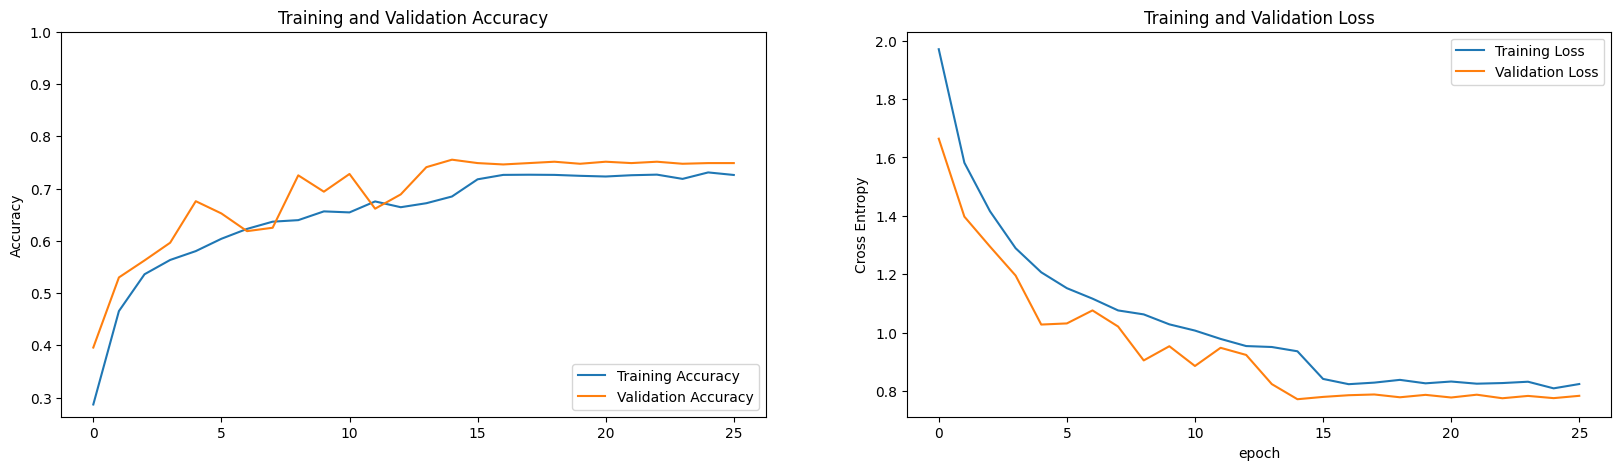

In [ ]:
acc += history_fine.history['accuracy']
loss += history_fine.history['loss']
val_acc += history_fine.history['val_accuracy']
val_loss += history_fine.history['val_loss']


plot_graph(acc, loss, val_acc, val_loss, FINE_TUNE_MODE_FIG)

# Evaluation

In [ ]:
loss, accuracy = model.evaluate(generated_test_data)
print('Test accuracy:', accuracy)

25/25 [==============================] - 32s 869ms/step - loss: 0.7221 - accuracy: 0.7723
Test accuracy: 0.7723270654678345


# model testing

In [ ]:
# path for the model
FINE_TUNE_MODEL_PATH = '/content/drive/MyDrive/ajmal/Dish_classification/Models/VGG19/fine_tune_model_trained.hdf5'
BASE_MODEL_PATH = '/content/drive/MyDrive/ajmal/Dish_classification/Models/VGG19/base_model_trained.hdf5'

# Load the  model
BASE_MODEL = tf.keras.models.load_model(BASE_MODEL_PATH)
FINE_TUNE_MODEL = tf.keras.models.load_model(FINE_TUNE_MODEL_PATH)



In [ ]:
img_path = '/content/drive/MyDrive/ajmal/Dish_classification/uehvdr_dataset/output/test/Banh tet/106.jpg'
predictions_with_base = predicted_output(img_path, BASE_MODEL, class_list)
predictions_with_tuned = predicted_output(img_path, FINE_TUNE_MODEL, class_list)

print(f'Base predicted class is {predictions_with_base} and Tuned predicted class is {predictions_with_tuned}')

1/1 [==============================] - 0s 160ms/step
Base predicted class is Banh tet and Tuned predicted class is Banh tet


In [ ]:
# Make the prediction
img_path = '/content/drive/MyDrive/ajmal/Dish_classification/uehvdr_dataset/output/test/Bun/120.jpg'  # Replace with your image path
predictions_with_base = predicted_output(img_path, BASE_MODEL, class_list)
predictions_with_tuned = predicted_output(img_path, FINE_TUNE_MODEL, class_list)

print(f'Base predicted class is {predictions_with_base} and Tuned predicted class is {predictions_with_tuned}')

1/1 [==============================] - 0s 19ms/step
Base predicted class is Bun and Tuned predicted class is Bun


# model EfficientNet

In [ ]:
# iniatialize the save path
PATH = '/content/drive/MyDrive/ajmal/Dish_classification/Models/EfficientNet'
BASE_MODEL_BEST, BASE_MODEL_TRAINED, BASE_MODEL_FIG, FINE_TUNE_MODEL_BEST, FINE_TUNE_MODEL_TRAINED, FINE_TUNE_MODE_FIG = save_model(PATH)

pretrained_model = EfficientNetB0(weights='imagenet', include_top=False)
last_output = pretrained_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=pretrained_model.input, outputs=outputs)

# Stage 1: Transfer learning


In [ ]:
for layer in pretrained_model.layers: layer.trainable = False
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    generated_train_data,
    validation_data = generated_validate_data,
    validation_steps = generated_validate_data.n // BATCH_SIZE,
    steps_per_epoch = generated_train_data.n // BATCH_SIZE,
    callbacks = [base_checkpointer, early_stopping],
    epochs = INITIAL_EPOCHS,
    verbose = 1,
)
model.save(BASE_MODEL_TRAINED)

Epoch 1/15
49/49 [==============================] - ETA: 0s - loss: 0.8757 - accuracy: 0.7144  
Epoch 1: val_loss improved from inf to 0.47324, saving model to /content/drive/MyDrive/ajmal/Dish_classification/Models/EfficientNet/base_model_best.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 5560s 113s/step - loss: 0.8757 - accuracy: 0.7144 - val_loss: 0.4732 - val_accuracy: 0.8385
Epoch 2/15
49/49 [==============================] - ETA: 0s - loss: 0.4986 - accuracy: 0.8316
Epoch 2: val_loss improved from 0.47324 to 0.34628, saving model to /content/drive/MyDrive/ajmal/Dish_classification/Models/EfficientNet/base_model_best.hdf5
49/49 [==============================] - 249s 5s/step - loss: 0.4986 - accuracy: 0.8316 - val_loss: 0.3463 - val_accuracy: 0.9023
Epoch 3/15
49/49 [==============================] - ETA: 0s - loss: 0.4263 - accuracy: 0.8552
Epoch 3: val_loss improved from 0.34628 to 0.31845, saving model to /content/drive/MyDrive/ajmal/Dish_classification/Models/EfficientNet/base_model_best.hdf5
49/49 [==============================] - 251s 5s/step - loss: 0.4263 - accuracy: 0.8552 - val_loss: 0.3185 - val_accuracy: 0.8906
Epoch 4/15
49/49 [==============================] - ETA: 0s - loss: 0.3791 - accuracy: 0.8727
Epoch 4: 

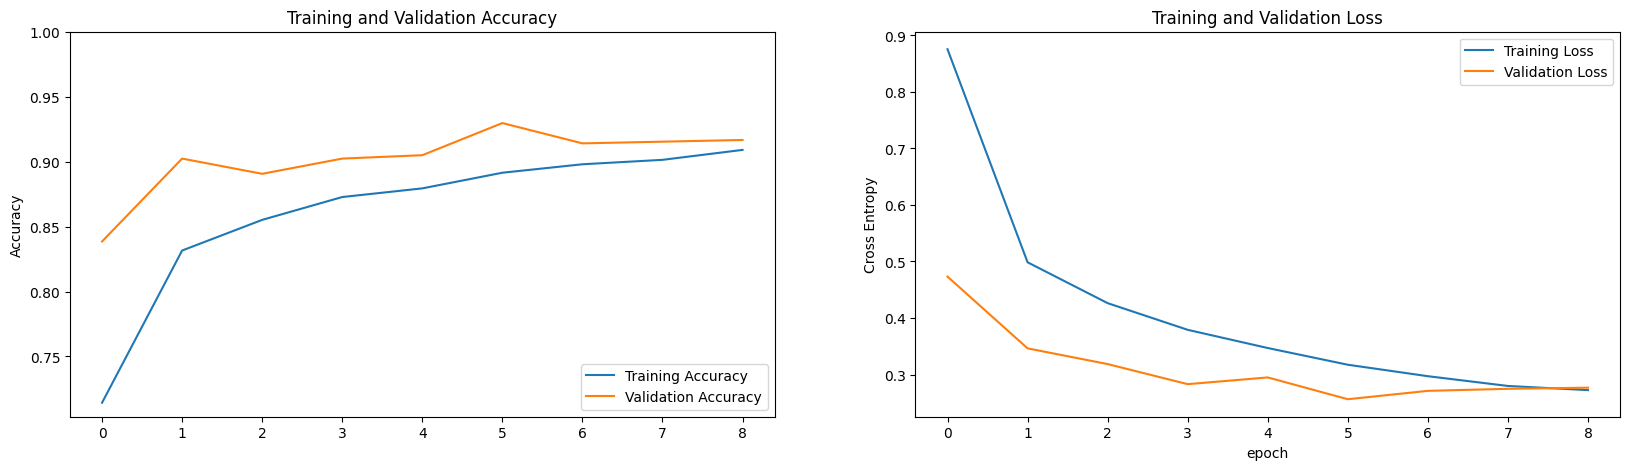

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
plot_graph(acc, loss, val_acc, val_loss, BASE_MODEL_FIG)

# Stage 2: Fine tuning

In [ ]:
for layer in pretrained_model.layers[:FINE_TUNE_AT]: layer.trainable = False
for layer in pretrained_model.layers[FINE_TUNE_AT:]: layer.trainable = True


model.compile(
    optimizer = SGD(learning_rate=1e-4, momentum=0.9),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)


history_fine = model.fit(
    generated_train_data,
    validation_data = generated_validate_data,
    validation_steps = generated_validate_data.n // BATCH_SIZE,
    steps_per_epoch = generated_train_data.n // BATCH_SIZE,
    epochs = TOTAL_EPOCHS,
    initial_epoch = history.epoch[-1],
    callbacks = [fine_tune_checkpointer, early_stopping],
    verbose = 1,
)
model.save(FINE_TUNE_MODEL_TRAINED)

Epoch 9/30
49/49 [==============================] - ETA: 0s - loss: 0.8722 - accuracy: 0.7128
Epoch 9: val_loss improved from inf to 0.26384, saving model to /content/drive/MyDrive/ajmal/Dish_classification/Models/EfficientNet/fine_tune_model_best.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 273s 5s/step - loss: 0.8722 - accuracy: 0.7128 - val_loss: 0.2638 - val_accuracy: 0.9219
Epoch 10/30
49/49 [==============================] - ETA: 0s - loss: 0.7596 - accuracy: 0.7562
Epoch 10: val_loss did not improve from 0.26384
49/49 [==============================] - 248s 5s/step - loss: 0.7596 - accuracy: 0.7562 - val_loss: 0.3105 - val_accuracy: 0.9036
Epoch 11/30
49/49 [==============================] - ETA: 0s - loss: 0.7020 - accuracy: 0.7818
Epoch 11: val_loss did not improve from 0.26384
49/49 [==============================] - 241s 5s/step - loss: 0.7020 - accuracy: 0.7818 - val_loss: 0.3681 - val_accuracy: 0.8867
Epoch 12/30
49/49 [==============================] - ETA: 0s - loss: 0.6626 - accuracy: 0.7956
Epoch 12: val_loss did not improve from 0.26384
49/49 [==============================] - 249s 5s/step - loss: 0.6626 - accuracy: 0.7956 - val_loss: 0.4245 - val_accuracy: 0.8685
Epoch 12: early stopping


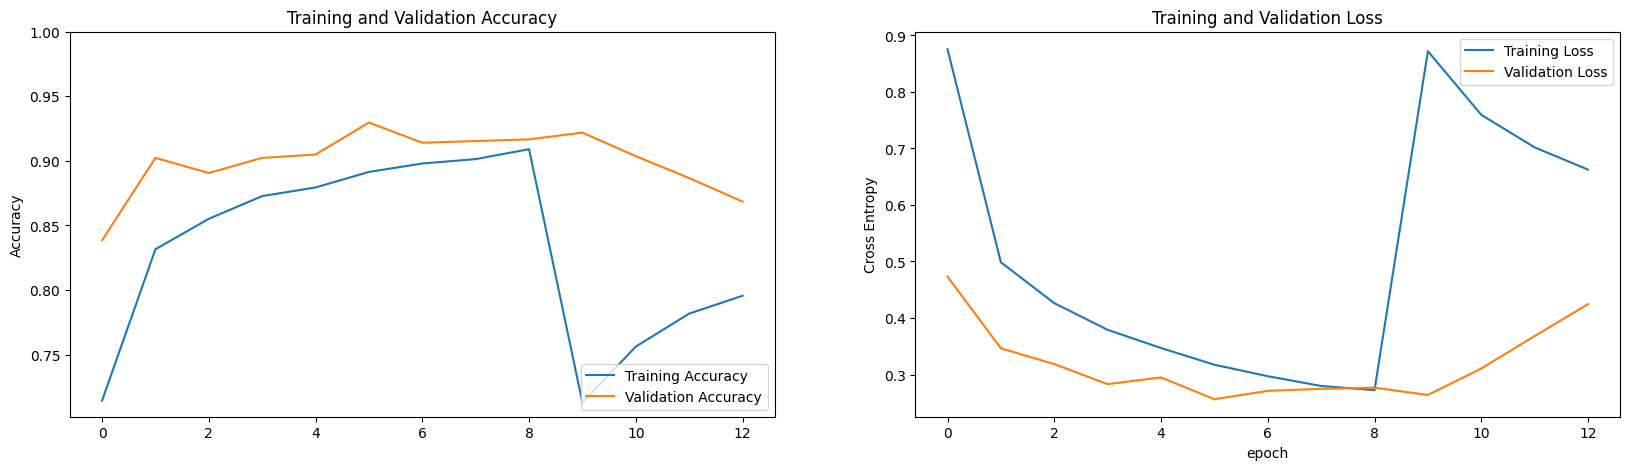

In [ ]:
acc += history_fine.history['accuracy']
loss += history_fine.history['loss']
val_acc += history_fine.history['val_accuracy']
val_loss += history_fine.history['val_loss']


plot_graph(acc, loss, val_acc, val_loss, FINE_TUNE_MODE_FIG)

#Evaluation

In [ ]:
loss, accuracy = model.evaluate(generated_test_data)
print('Test accuracy:', accuracy)

25/25 [==============================] - 606s 25s/step - loss: 0.4527 - accuracy: 0.8579
Test accuracy: 0.8578616380691528


# model testing

In [ ]:
# path for the model
FINE_TUNE_MODEL_PATH = '/content/drive/MyDrive/ajmal/Dish_classification/Models/EfficientNet/fine_tune_model_trained.hdf5'
BASE_MODEL_PATH = '/content/drive/MyDrive/ajmal/Dish_classification/Models/EfficientNet/base_model_best.hdf5'

# Load the  model
BASE_MODEL = tf.keras.models.load_model(BASE_MODEL_PATH)
FINE_TUNE_MODEL = tf.keras.models.load_model(FINE_TUNE_MODEL_PATH)



In [ ]:
img_path = '/content/drive/MyDrive/ajmal/Dish_classification/uehvdr_dataset/output/test/Banh tet/106.jpg'
predictions_with_base = predicted_output(img_path, BASE_MODEL, class_list)
predictions_with_tuned = predicted_output(img_path, FINE_TUNE_MODEL, class_list)

print(f'Base predicted class is {predictions_with_base} and Tuned predicted class is {predictions_with_tuned}')

1/1 [==============================] - 1s 1s/step
Base predicted class is Banh tet and Tuned predicted class is Banh tet


In [ ]:
# Make the prediction
img_path = '/content/drive/MyDrive/ajmal/Dish_classification/uehvdr_dataset/output/test/Bun/120.jpg'  # Replace with your image path
predictions_with_base = predicted_output(img_path, BASE_MODEL, class_list)
predictions_with_tuned = predicted_output(img_path, FINE_TUNE_MODEL, class_list)

print(f'Base predicted class is {predictions_with_base} and Tuned predicted class is {predictions_with_tuned}')

1/1 [==============================] - 0s 24ms/step
Base predicted class is Bun and Tuned predicted class is Bun


# model comparisons.
- load all models

In [ ]:
# path for the model
XCEPTION_BASE_MODEL_PATH = '/content/drive/MyDrive/ajmal/Dish_classification/Models/Xception/base_model_best.hdf5'
XCEPTION_FINE_TUNE_MODEL_PATH ='/content/drive/MyDrive/ajmal/Dish_classification/Models/Xception/fine_tune_model_best.hdf5'
VGG19_BASE_MODEL_PATH = '/content/drive/MyDrive/ajmal/Dish_classification/Models/VGG19/base_model_trained.hdf5'
VGG19_FINE_TUNE_MODEL_PATH ='/content/drive/MyDrive/ajmal/Dish_classification/Models/VGG19/fine_tune_model_trained.hdf5'
EFFICIENTNET_BASE_MODEL_PATH ='/content/drive/MyDrive/ajmal/Dish_classification/Models/EfficientNet/base_model_best.hdf5'
EFFICIENTNET_FINE_TUNE_MODEL_PATH ='/content/drive/MyDrive/ajmal/Dish_classification/Models/EfficientNet/fine_tune_model_best.hdf5'

In [ ]:
# Load the  model
XCEPTION_BASE_MODEL = tf.keras.models.load_model(XCEPTION_BASE_MODEL_PATH)
XCEPTION_FINE_TUNE_MODEL = tf.keras.models.load_model(XCEPTION_FINE_TUNE_MODEL_PATH)
VGG19_BASE_MODEL = tf.keras.models.load_model(VGG19_BASE_MODEL_PATH)
VGG19_FINE_TUNE_MODEL = tf.keras.models.load_model(VGG19_FINE_TUNE_MODEL_PATH)
EFFICIENTNET_BASE_MODEL = tf.keras.models.load_model(EFFICIENTNET_BASE_MODEL_PATH)
EFFICIENTNET_FINE_TUNE_MODEL = tf.keras.models.load_model(EFFICIENTNET_FINE_TUNE_MODEL_PATH)

In [ ]:
# Evaluation of all models
def evaluate_model(model):
  loss, accuracy = model.evaluate(generated_test_data)
  return loss, accuracy

In [ ]:
XB_loss, XB_accuracy = evaluate_model(XCEPTION_BASE_MODEL)
XF_loss, XF_accuracy = evaluate_model(XCEPTION_FINE_TUNE_MODEL)
VB_loss, VB_accuracy = evaluate_model(VGG19_BASE_MODEL)
VF_loss, VF_accuracy = evaluate_model(VGG19_FINE_TUNE_MODEL)
EB_loss, EB_accuracy = evaluate_model(EFFICIENTNET_BASE_MODEL)
EF_loss, EF_accuracy = evaluate_model(EFFICIENTNET_FINE_TUNE_MODEL)

25/25 [==============================] - 13s 522ms/step - loss: 0.3042 - accuracy: 0.9069


In [ ]:
print(f'XCEPTION_BASE_MODEL Test accuracy {XB_accuracy:.2f} and Loss {XB_loss:.2f}')
print(f'XCEPTION_FINE_TUNE_MODEL Test accuracy {XF_accuracy:.2f} and Loss {XF_loss:.2f}')
print(f'VGG19_BASE_MODEL Test accuracy {VB_accuracy:.2f} and Loss {VB_loss:.2f}')
print(f'VGG19_FINE_TUNE_MODEL Test accuracy {VF_accuracy:.2f} and Loss {VF_loss:.2f}')
print(f'EFFICIENTNET_BASE_MODEL Test accuracy {EB_accuracy:.2f} and Loss {EB_loss:.2f}')
print(f'EFFICIENTNET_FINE_TUNE_MODEL Test accuracy {EF_accuracy:.2f} and Loss {EF_loss:.2f}')

XCEPTION_BASE_MODEL Test accuracy 0.91 and Loss 0.30
XCEPTION_FINE_TUNE_MODEL Test accuracy 0.91 and Loss 0.29
VGG19_BASE_MODEL Test accuracy 0.77 and Loss 0.71
VGG19_FINE_TUNE_MODEL Test accuracy 0.77 and Loss 0.72
EFFICIENTNET_BASE_MODEL Test accuracy 0.90 and Loss 0.31
EFFICIENTNET_FINE_TUNE_MODEL Test accuracy 0.91 and Loss 0.30


# user application

In [1]:
!pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 10.1 MB/s

In [12]:
import gradio as gr
from PIL import Image

In [15]:
EFFICIENTNET_FINE_TUNE_MODEL_PATH ='/content/drive/MyDrive/ajmal/Dish_classification/Models/EfficientNet/fine_tune_model_best.hdf5'
EFFICIENTNET_FINE_TUNE_MODEL = tf.keras.models.load_model(EFFICIENTNET_FINE_TUNE_MODEL_PATH)

In [14]:
class_list

['Banh chung',
 'Banh mi',
 'Banh tet',
 'Banh trang',
 'Banh xeo',
 'Bun',
 'Com tam',
 'Goi cuon',
 'Pho']

In [16]:

def predict_output(img):
    if img is None:
        return "No image uploaded or the image format is not supported."

    # Resize the image to the required size
    img = img.resize(IMAGE_SIZE)
    x = image.img_to_array(img)
    x = preprocess_input(x)
    x = tf.expand_dims(x, axis=0)

    # Make the prediction
    predictions = EFFICIENTNET_FINE_TUNE_MODEL.predict(x)

    # Decode the prediction
    class_index = tf.argmax(predictions[0]).numpy()
    return class_list[class_index]


# Create a Gradio interface
interface = gr.Interface(
    fn=predict_output,
    inputs=gr.Image(type="pil"),  # Specify that the input is an image in PIL format
    outputs="text",  # The output is a text message
    title="Image Saver",
    description="Upload an image and save it to a temporary path."
)

# Launch the Gradio interface
interface.launch(debug=True)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://5d2c43957b1589fbc1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 29ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://5d2c43957b1589fbc1.gradio.live
